In [1]:
import matplotlib
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mite.filters import ParallelFilter
from mite.filters.time import MeanAbsoluteValueFilter, VarianceFilter, WaveformLengthFilter, SlopeSignChangeFilter, \
    ZeroCrossingsFilter
from mite.filters.wavelet.WaveletTransformFilter import WaveletTransformFilter
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
matplotlib.use('QT5Agg')
%matplotlib inline

In [2]:
hf = h5py.File('s15data.mat', 'r')
data = hf.get('dat')
data = np.array(data)

In [3]:
y = data[8, :]
y_means = np.mean(y.reshape(-1, 100), axis=1)
diff = (np.max(y) - np.min(y))/3
bins = np.array([np.min(y), np.min(y) + diff, np.min(y) + 2*diff, np.max(y)])
y_binned = np.digitize(y_means, bins)

ds_data = data[:, ::10]
sampling_rate = 10240

# processing variables
window_size = 100
window_step = 100

In [4]:
td5 = ParallelFilter(filters=[MeanAbsoluteValueFilter(),
                              VarianceFilter(),
                              WaveformLengthFilter(),
                              SlopeSignChangeFilter(),
                              ZeroCrossingsFilter()])

cwt = WaveletTransformFilter()

In [5]:
window = []
tfeat = []
features = []

sample = 0
t = 0
for sample in tqdm(range(0, np.shape(data)[1], 100)):
    window = data[0:6, sample:sample+100]  # grab device measurements
    features.append(cwt.filter(np.transpose(window)))  # extract features
    t = (sample + 100) / sampling_rate
    tfeat.append(t)  # save timestamp

raw = data[0:sample]
traw = range(sample)
tfeat = np.hstack(tfeat)
features = np.array(features)
features = np.vstack(features)

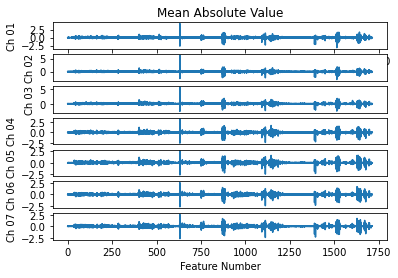

In [11]:
fig = plt.figure()
for i in range(7):
    ax = fig.add_subplot(7, 1, i + 1)
    ax.plot(tfeat, features[:, i])

    # ax.set_ylim( 0.35, 0.65 )
    ax.set_ylabel('Ch %02d' % (i + 1))

    if i == 0:
        ax.set_title('Mean Absolute Value')
    elif i == 6:
        ax.set_xlabel('Feature Number')
    else:
        ax.set_xticks([])
plt.show()

In [12]:
pca = PCA(n_components=10)
pca.fit(features)
X = pca.transform(features)
y = y_binned[:np.shape(features)[0]]

In [13]:
np.save('wt_features', features)
np.save('wt_features_pca', X)

Feature 0: 1.078293 0.340178
Feature 1: 0.655020 0.519433
Feature 2: 0.471891 0.623822
Feature 3: 1.652317 0.191608
Feature 4: 4.142221 0.015889
Feature 5: 3.235641 0.039337
Feature 6: 1.284098 0.276903
Feature 7: 1.597049 0.202496
Feature 8: 0.318563 0.727193
Feature 9: 0.275045 0.759538


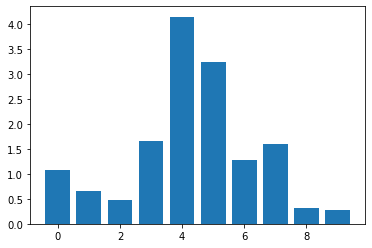

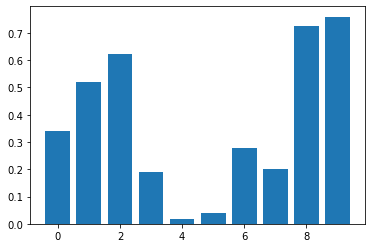

In [14]:
f, p = f_classif(X, y)
for i in range(len(f)):
    print('Feature %d: %f %f' % (i, f[i], p[i]))
# plot the scores
plt.bar([i for i in range(len(f))], f)
plt.show()
plt.bar([i for i in range(len(p))], p)
plt.show()

In [15]:
np.shape(ds_data)

(17, 1754700)

In [16]:
y_ds = data[8, ::10]
y_ds_means = np.mean(y_ds.reshape(-1, 50), axis=1)
diff = (np.max(y_ds) - np.min(y_ds))/3
bins = np.array([np.min(y_ds), np.min(y_ds) + diff, np.min(y_ds) + 2*diff, np.max(y_ds)])
y_ds_binned = np.digitize(y_ds_means, bins)
y_ds = y_ds_binned
ds_data = data[:, ::10]

In [17]:
td5_features = []
for sample in tqdm(range(0, np.shape(ds_data)[1], 50)):
    window = ds_data[0:6, sample:sample+50]  # grab device measurements
    td5_features.append(td5.filter(np.transpose(window)))  # extract features

In [18]:
# TD5 Featureset
td5_features = np.vstack(np.array(td5_features))
f, p = f_classif(td5_features, y_ds)
outfile.write("TD5 Featureset")
for i in range(len(f)):
    print('Feature %d: %f %f' % (i, f[i], p[i]))

NameError: name 'outfile' is not defined

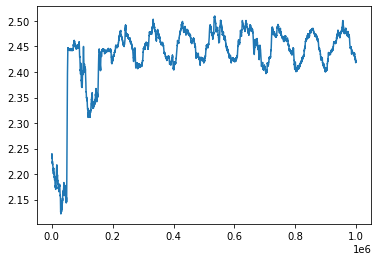

In [62]:
y = data[11, :]
plt.plot(y[4000000:5000000])

In [7]:
np.where(y > 2.5)

(array([  141739,   141740,   141741, ..., 17542233, 17542234, 17542235]),)

In [40]:
y_means = np.mean(y.reshape(-1, 1000), axis=1)

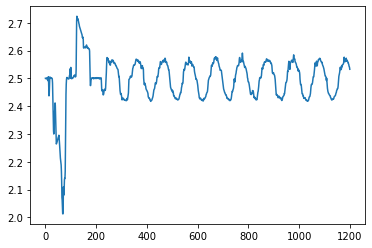

In [47]:
plt.plot(y_means[300:1500])

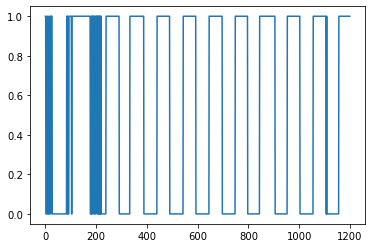

In [44]:
y_bin = np.zeros(np.shape(y_means))
y_bin[y_means > 2.5] = 1
plt.plot(y_bin[300:1500])

In [42]:
from utils import class_bin, feature_extract, anova_test

In [49]:
percs = []
f_s_s = []
p_s_s = []
feats = ['td5', 'ar', 'ft', 'dwt']
classes = [[8, 3, 2.49, 2,51], [10, 3, 2.49, 2,51], [9, 3, 2.44, 2.46], [11, 3, 2.44, 2.46]]
for ind, n_classes, low, high in classes:
    y = class_bin(data[ind, :], 1000, n_classes, low, high)
    perc = []
    f_s = []
    p_s = []
    for feat in feats:
        td5_features = feature_extract(data[0:6, :], feat, 1000, 1000)
        f, p = anova_test(td5_features, y)
        f_s += [f]
        p_s += [p]
        perc += [sum(p < 0.05)/len(p)]
    percs += [perc]
    f_s_s += f_s
    p_s_s += p_s

  0%|          | 96/35094 [00:00<00:36, 957.39it/s]

Extracting td5 features:


  0%|          | 0/35094 [00:00<?, ?it/s]

[ 2231.515  1248.351  1876.193  3004.771  2435.499  2752.671   378.62
   117.605   179.032  1118.176   535.496   173.042  2078.475  1980.838
  1657.264  2397.371  1856.562  4061.966  3625.108  1803.406  5206.958
  8391.441  7578.78  11766.872  6132.192   741.935  7066.978  8869.286
  8756.775  8761.81 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Extracting ar features:


100%|██████████| 35094/35094 [13:53<00:00, 42.12it/s] 


[   0.571 4919.438 3373.912 3378.001 3587.663 2933.233 1067.392    0.076
 2654.228 2465.361 1899.037 1356.46   622.135 1444.652    2.15  6168.999
 4803.21  4498.42  4662.278 3644.29  3204.147    0.104 9157.709 7836.964
 7094.644 7296.621 5320.82  2787.284    0.951 7190.3   4898.973 3978.029
 4667.225 3743.987 2524.476    0.199 9871.538 6972.442 5116.815 7411.776
 3331.763  347.433]
[0.565 0.    0.    0.    0.    0.    0.    0.927 0.    0.    0.    0.
 0.    0.    0.116 0.    0.    0.    0.    0.    0.    0.902 0.    0.
 0.    0.    0.    0.    0.386 0.    0.    0.    0.    0.    0.    0.82
 0.    0.    0.    0.    0.    0.   ]


  1%|          | 277/35094 [00:00<00:12, 2767.95it/s]

Extracting ft features:


  1%|          | 353/35094 [00:00<00:09, 3524.57it/s]

[4256.08   738.936  988.025  190.994  115.852 1079.255    4.115  374.705
  128.488    1.026    1.69    13.482   79.369   80.337    1.145    6.396
  194.882   14.868   37.454   52.183    1.706   16.615    1.081   22.089]
[0.    0.    0.    0.    0.    0.    0.016 0.    0.    0.358 0.185 0.
 0.    0.    0.318 0.002 0.    0.    0.    0.    0.182 0.    0.339 0.   ]
Extracting dwt features:


100%|██████████| 35094/35094 [00:15<00:00, 2277.00it/s]


[0.146 0.285 1.145 0.056 0.015 0.473 0.238 0.57  0.707 0.111 0.294 0.097
 0.332 3.173 0.675 0.005 0.517 0.401 0.407 1.153 0.016 0.715 0.21  0.211]
[0.864 0.752 0.318 0.945 0.985 0.623 0.789 0.566 0.493 0.895 0.745 0.908
 0.717 0.042 0.509 0.995 0.597 0.67  0.666 0.316 0.984 0.489 0.81  0.81 ]


In [53]:
percs = [perc]

<BarContainer object of 4 artists>

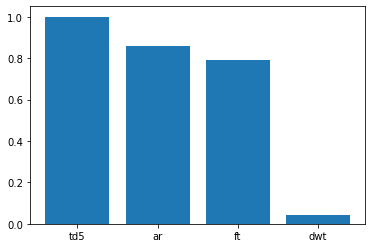

In [52]:
perc = []
feats = ['td5', 'ar', 'ft', 'dwt']
f_s = []
p_s = []
y = class_bin(data[9, :], 500, n_classes = )
for feat in feats:
    td5_features = feature_extract(data[0:6, :], feat, 500, 500)
    f, p = anova_test(td5_features, y)
    f_s += [f]
    p_s += [p]
    perc += [sum(p < 0.05)/len(p)]